In [928]:
import pandas as pd
import requests
import datetime
import numpy as np
from datetime import datetime
import time
from time import sleep
import json
import random

In [929]:
def getPushshiftData(query, after, before, sub, endpoint = 'submission', size = 25, score = '>9'):
    url = 'https://api.pushshift.io/reddit/search/' + endpoint
    parameters = {'subreddit': sub, 'title' : query, 'after' : str(after), 'before' : str(before), 'size': 500}
    
    if endpoint == 'comment':
        parameters['score'] = '>9'
        print('comment')
        print(paramters['score'])
    r = requests.get(url, parameters)
    try:
        data = r.json()
    except:
        data = {'data':[]}
        
    return data['data']

In [930]:
def collectSubData(subm, subStats):
    #subData = list() #list to store data points
    
    pd.DataFrame
    title = subm['title']
    url = subm['url']
    
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
        
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc'])
    numComms = subm['num_comments']
    permalink = subm['permalink']
    text = subm['selftext']
    
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair))
    subStats[sub_id] = subData

In [931]:
def extractStats(data):
    
    subStats = {}
    subCount = 0
    
    while len(data) > 0:
        print(len(data), end = ' , ')
        for submission in data:
            collectSubData(submission, subStats)
            subCount+=1
            
        # Calls getPushshiftData() with the created date of the last submission
        print(len(data), end = " , ")
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])), end = ' , ')
        after = data[-1]['created_utc']
        data = getPushshiftData(query, after, before, sub)

    print(len(data))
    return(subStats)

Code snippets from https://rareloot.medium.com/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [932]:
def dt2unix(before, after, format = "%Y/%m/%d"):
    # input: two strings in the form yyyy/mm/dd
    # returns: tuple (before, after) as unix times
    beforeUnix = time.mktime(datetime.strptime(before, format).timetuple())
    afterUnix = time.mktime(datetime.strptime(after, format).timetuple())
    
    return(int(beforeUnix), int(afterUnix))

In [933]:
def extractData(data):
    dataDF = pd.DataFrame(data)
    toExtract = ['author',
                 'subreddit',
                  'created_utc',
                  'full_link', 
                  'id', 'is_self', 
                  'is_video', 
                  'locked', 
                  'num_comments', 
                  'num_crossposts', 
                  'pinned', 
                  'score',
                 'selftext',
                  'title',
                'body']
    outDF = pd.DataFrame([])
    for query in toExtract:
        try:
            outDF[query] = dataDF[query]
        except:
            pass
        
    return(outDF)

In [934]:
def getNews(query, after, before, sublist = ['news','worldnews','gunpolitics'], endpoint = 'submission'):
    combinedDF = pd.DataFrame()
    after0 = after
    for sub in sublist:
        print("\n")
        print(sub)
        datai = getPushshiftData(query, after0, before, sub, endpoint)
        i = 1
        while(len(datai) > 0):
            print(len(datai), end = ' ')
            dataj = extractData(datai)
            combinedDF = combinedDF.append(dataj)
            after = datai[-1]['created_utc']
            
            print(after, end = ' , ')
            
            if i % 10 == 0:
                print("\n")
            i+=1
            
            datai = getPushshiftData(query, after, before, sub, endpoint)
            sleep(random.random())
            
    return(combinedDF)

In [935]:
class RedditData:
    dataframe = pd.DataFrame()
    datalist = []
    
    
    
    def __init__(self):
        pass
    
    def collect(self, subs, terms, startdate, enddate, endpoint = 'submission'):
        
        # assert that subs, dates, and terms are nonempty
        assert(len(subs) > 0), "Search a Subreddit"
        assert(len(terms) > 0), "Pick a searchterm"
        
        
        after, before = dt2unix(startdate, enddate)
        
        
        if type(terms) == list:
            print(terms)
            for term in terms:
                print(term)
                self.datalist.append(term)
                stories = getNews(term, after, before, subs, endpoint)
                stories.insert(0, "Search Term", term)
                self.dataframe = self.dataframe.append(stories)
                
        else:
            print(terms)
            stories = getNews(terms, after, before, subs, endpoint)
            stories.insert(0, "Search Term", terms)
            self.dataframe = self.dataframe.append(stories)
            
    def getdata(self):
        return(self.dataframe)

In [936]:
#This set of start stop contains the european 2019 heatwave
start = '2018/1/1'
stop = '2021/1/1'

In [937]:
stories = RedditData()
stories.collect(['news','worldnews','TrueNews', "InDepthStories"], "heat wave", start,stop)

heat wave


news
100 1565826649 , 100 1599182343 , 6 1602615593 , 

worldnews
100 1561632421 , 100 1582566347 , 100 1597602987 , 13 1606816378 , 

TrueNews
3 1595210651 , 

InDepthStories
6 1599184046 , 

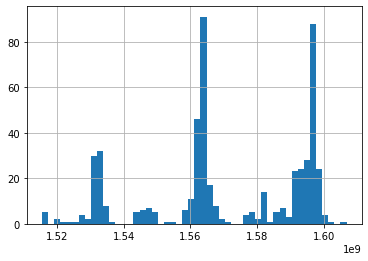

In [938]:
stories.getdata()['created_utc'].hist(bins = 50)

In [939]:
stories.getdata()['score']

0    44
1     1
2    31
3     1
4    23
     ..
1     1
2     1
3     1
4     1
5     1
Name: score, Length: 528, dtype: int64

In [940]:
p = stories.getdata()['created_utc'].apply(datetime.fromtimestamp).value_counts()

In [941]:
cutoff = 10

In [942]:
timesvalues = p > cutoff

In [943]:
timesvalues

2018-07-19 08:02:34    False
2018-07-05 00:51:28    False
2020-06-25 17:45:56    False
2019-08-13 22:02:04    False
2019-06-26 14:39:55    False
                       ...  
2020-08-16 10:36:19    False
2018-12-29 19:07:07    False
2020-07-20 03:47:29    False
2020-08-20 02:34:25    False
2018-08-27 14:06:27    False
Name: created_utc, Length: 528, dtype: bool

In [944]:
counts, rEdge = np.histogram(stories.getdata()['created_utc'], bins = 50)
counts

array([ 5,  0,  2,  1,  1,  1,  4,  2, 30, 32,  8,  1,  0,  0,  0,  5,  6,
        7,  5,  0,  1,  1,  0,  6, 11, 46, 91, 17,  8,  2,  1,  0,  0,  4,
        5,  2, 14,  1,  5,  7,  3, 23, 24, 28, 88, 24,  4,  1,  0,  1])

In [945]:
"""
if counts[0] > cutoff:
    tSeries = 1*(rEdge[0] > times).to_numpy()
else:
    tSeries = 0
    
for i in range(1, len(counts)):
    if counts[i] > cutoff:
        tSeries += ((rEdge[i-1] <= times) & (rEdge[i] > times)).to_numpy()
"""

'\nif counts[0] > cutoff:\n    tSeries = 1*(rEdge[0] > times).to_numpy()\nelse:\n    tSeries = 0\n    \nfor i in range(1, len(counts)):\n    if counts[i] > cutoff:\n        tSeries += ((rEdge[i-1] <= times) & (rEdge[i] > times)).to_numpy()\n'

In [946]:
intervals = []
for i in range(len(counts)):
    if counts[i] >= cutoff:
        intervals.append((rEdge[i],rEdge[i+1]))

In [947]:
print(intervals)

[(1530123013.0, 1531949045.5), (1531949045.5, 1533775078.0), (1559339533.0, 1561165565.5), (1561165565.5, 1562991598.0), (1562991598.0, 1564817630.5), (1564817630.5, 1566643663.0), (1581251923.0, 1583077955.5), (1590382085.5, 1592208118.0), (1592208118.0, 1594034150.5), (1594034150.5, 1595860183.0), (1595860183.0, 1597686215.5), (1597686215.5, 1599512248.0)]


In [948]:
def heat(x, intervals):
    for edge in intervals:
        if (x >= edge[0]) & (x <= edge[1]):
            return 1
    return 0

In [ ]:
sublist = ['wallstreetbets', 'stocks', 'investing','finance', 'BullGangOfficial','Superstonk']
stories.collect(sublist, '*',  start,stop)
#stories.collect(['stocks','wallstreetbets','personalfinance','investing'], ['merger','penis','moon','rocket','unicorn','disaster','due dilligence', 'bull', 'bear', 'profit','loss','hedge','IPO', 'Nasdaq','meme','portfolio','spy', 'vix'],  start,stop)

*


wallstreetbets
100 1514904704 , 100 1514941087 , 100 1514996829 , 100 1515022543 , 100 1515081590 , 100 1515122232 , 100 1515182050 , 100 1515266889 , 100 1515375350 , 100 1515432373 , 

100 1515499679 , 100 1515532520 , 100 1515596411 , 100 1515620464 , 100 1515686021 , 100 1515710772 , 100 1515774260 , 100 1515810287 , 100 1515974204 , 100 1516070845 , 

100 1516129517 , 100 1516169525 , 100 1516220961 , 100 1516285134 , 100 1516314676 , 100 1516380510 , 100 1516428064 , 100 1516575748 , 100 1516645756 , 100 1516677092 , 

100 1516728996 , 100 1516749906 , 100 1516807977 , 100 1516830855 , 100 1516893179 , 100 1516907009 , 100 1516931376 , 100 1516986035 , 100 1517003105 , 100 1517078203 , 

100 1517173958 , 100 1517239314 , 100 1517262491 , 100 1517320449 , 100 1517334845 , 100 1517352482 , 100 1517395912 , 100 1517425083 , 100 1517439127 , 100 1517494388 , 

100 1517515962 , 100 1517532768 , 100 1517583213 , 100 1517592693 , 100 1517602792 , 100 1517615146 , 100 1517670572 , 10

In [ ]:
len(stories.getdata()['created_utc'].unique())

In [ ]:
#stories.getdata().to_csv('wsb_100.csv')


In [ ]:
#stories.getdata()[stories.getdata()['subreddit'] == 'wallstreetbets']

In [ ]:
stockstories = stories.getdata()[stories.getdata()['Search Term'] != "heat wave"]
#stockstories = stockstories[stockstories['num_comments'] > 5]
#stockstories = pd.DataFrame() 
#stocksinv = pd.read_csv('stocks_investing.csv')
#wsbstocks = pd.read_csv('wsb_100.csv')
#stockstories = stockstories.append(wsbstocks)
#stockstories = stockstories.append(stocksinv)

In [ ]:
#df = (stockstories[stockstories['subreddit'] == 'wallstreetbets']['created_utc'])

#pd.to_datetime(min(df), unit = 's'), pd.to_datetime(max(df), unit = 's')

In [ ]:
#dates = stockstories[stockstories['subreddit'] == 'investing']['created_utc']
#print(pd.to_datetime(min(dates), unit = 's').date(), pd.to_datetime(max(dates), unit = 's').date())

In [ ]:
#start,stop = (pd.to_datetime(min(dates), unit = 's').date(), pd.to_datetime(max(dates), unit = 's').date())

In [ ]:
#times = stories.getdata()['created_utc']
#tSeries = stories.getdata()['created_utc'].apply(lambda x: heat(x, intervals))
times = stockstories['created_utc']
tSeries = stockstories['created_utc'].apply(lambda x: heat(x, intervals))

In [ ]:
tSeries

In [ ]:
pd.DataFrame({'Times': pd.to_datetime(times, unit = 's'), 'Heatwave' : tSeries})

In [ ]:
#df_sentiment = stories.getdata().loc[:,['title','created_utc','Search Term']]
df_sentiment = stockstories.loc[:,['title','created_utc', 'subreddit']]
#df_sentiment = stockstories.loc[:,['body','created_utc','subreddit']]
heat_utc = pd.DataFrame({'created_utc': times, 'Heatwave' : tSeries})
df_sentiment = pd.merge(df_sentiment, heat_utc)
df_sentiment['Date'] = pd.to_datetime(df_sentiment['created_utc'], unit = 's').apply(lambda x: x.date())
df_sentiment.index.name = ''
df_sentiment = df_sentiment.drop(columns = 'created_utc')
df_sentiment.index = [e for e in range(len(df_sentiment))]

Make a dataframe to store the unmodified titles.  They must be cleaned and have sentiment analysis performed on them.

In [ ]:
from textblob import TextBlob, Word
from nltk.corpus import stopwords


In [ ]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.lower().tags if w not in stopwords.words('english')]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
vds = SentimentIntensityAnalyzer()

In [ ]:
vds.polarity_scores(df_sentiment['title'].iloc[0])['compound']

In [ ]:
df_sentiment['sentiment'] = df_sentiment['title'].apply(lambda x: vds.polarity_scores(x)['compound'])
df_sentiment.sample(4)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

colors = {0:'blue',1:'red'}

grouped = df_sentiment.groupby('Heatwave')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='sentiment', y = 'Heatwave', label=key, color=colors[key])

plt.show()

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import yahoo_fin.stock_info as si

stocksinfo = si.get_data('SPY', start_date = start, end_date = stop)['adjclose']

In [ ]:
df_stocksinfo = pd.DataFrame({'Close':stocksinfo, 'Date': stocksinfo.index})
#stocksinfo.index = [e for e in range(len(stocksinfo))]
df_stocksinfo.index = [e for e in range(len(stocksinfo))]

In [ ]:
df_sentiment = df_sentiment.sort_values(by = 'Date')

In [ ]:
aggregate_sentiment = []
days = df_sentiment['Date'].unique()
for i,e in enumerate(days):
    
    
    #toadd = 0
    #for sub in sublist:
    #    meanadd = df_sentiment[df_sentiment['subreddit']== sub][df_sentiment['Date'] == e]['sentiment'].mean()
    #    if np.isnan(meanadd):
    #        meanadd = 0
            
    #    toadd += meanadd
    
    toadd = df_sentiment[~df_sentiment['subreddit'].isin(['wallstreetbets', 'finance'])][df_sentiment['Date'] == e]['sentiment'].sum()
    #toadd = df_sentiment[df_sentiment['Date'] == e]['sentiment'].sum()
    
    #if i != 0:
    #    toadd = toadd + aggregate_sentiment[-1]
    
    aggregate_sentiment.append(toadd)

In [ ]:
sublist

In [ ]:
ag_sent_date = pd.DataFrame({'Date': days, 'sentiment':aggregate_sentiment})

In [ ]:
ag_sent_date['Date'] = pd.to_datetime(ag_sent_date['Date'])
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])

In [ ]:
df_stocks_sentiment = pd.merge(df_stocksinfo, ag_sent_date, on = 'Date').sort_values(by = 'Date')

In [ ]:
df_stocks_sentiment['Close'].plot()
df_stocks_sentiment['sentiment'].plot(secondary_y = True)

In [ ]:
dates = df_stocks_sentiment['Date']
(pd.to_datetime(min(dates), unit = 's').date(),pd.to_datetime(max(dates), unit = 's').date())

In [ ]:
hwaves = (df_stocks_sentiment['Date'].astype(int)/10**9).apply(lambda x: heat(x, intervals))
hwaves

In [ ]:
df_stocks_sentiment['Heat Wave'] = hwaves

In [ ]:

fig, ax = plt.subplots()

colors = {0:'blue',1:'red'}

grouped = df_stocks_sentiment.groupby('Heat Wave')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='sentiment', y = 'Heat Wave', label=key, color=colors[key])

plt.show()

In [ ]:
hws = df_stocks_sentiment['Heat Wave']#np.where(df_stocks_reduced['Heat Wave'] == 1)

In [ ]:
leading_edges = []
following_edges = []
for i in range(len(hws)):
    if hws[i] == 1:
        if i == 0:
            leading_edges.append(i)
        elif hws[i-1] == 0 :
            leading_edges.append(i)
        
    if hws[i] == 0 :
        if i != 0:
            if hws[i-1] == 1 :
                following_edges.append(i)
                
if len(leading_edges) != len(following_edges):
    if min(leading_edges) > min(following_edges):
        leading_edges = [0] + leading_edges
        
    if max(leading_edge) > max(following_edges):
        following_edges = following_edges + [len(hws)]

In [ ]:
#df_stocks_reduced.index = [e for e in range(len(df_stocks_reduced))]
df_stocks_sentiment.index = pd.to_datetime(df_stocks_reduced['Date'])
print(leading_edges,"\n",following_edges)

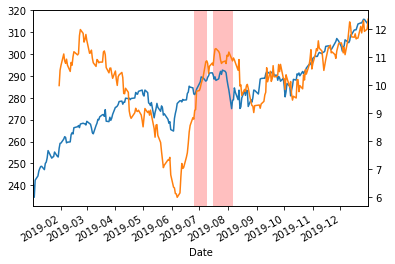

In [925]:

#df_stocks_reduced['Close'].plot()
#df_stocks_reduced['sentiment'].plot(secondary_y = True)

ax = df_stocks_sentiment['Close'].plot()
for i,j in zip(df_stocks_sentiment['Date'].iloc[leading_edges], df_stocks_reduced['Date'].iloc[following_edges]):
    ax.axvspan(i,j, facecolor = 'red', alpha= 0.25)
    
df_stocks_reduced['avg5'] = df_stocks_sentiment['sentiment'].rolling(20).mean()
df_stocks_reduced['avg5'].plot(secondary_y = True)
#ax2 = df_stocks_reduced.plot(x = 'Date', y = 'sentiment', secondary_y = True)

#plt.show()